In [1]:
import numpy as np
import os, cv2, torch, config
import matplotlib.pyplot as plt

#from REKD.evaluation.extract_hpatches import MultiScaleFeatureExtractor
from training.model.REKD import REKD, count_model_parameters

In [3]:
args = config.get_config(jupyter=True)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
args.load_dir =  'trained_models/release_group36_f2_s2_t2.log/best_model.pt'


model = REKD(args, device)
model.load_state_dict(torch.load(args.load_dir))  ## Load the PyTorch learnable model parameters.

model.export()
model.eval()
model = model.to(device) ## use GPU


print("Model paramter : {} is loaded.".format( args.load_dir ))
count_model_parameters(model)

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [3]:
print(device)

cpu


In [4]:
image_path1 = os.path.join(os.getcwd(), "images/sample.jpg")

img1 = cv2.cvtColor(cv2.imread(image_path1), cv2.COLOR_BGR2GRAY)[np.newaxis, :, :]  ## (1, H, W)
img1 = img1.astype(float) / img1.max()

In [5]:
img1 = torch.Tensor(img1)

img1.shape

torch.Size([1, 576, 720])

In [6]:
img1 = torch.tensor(img1).unsqueeze(0).to(torch.float32)
im_scores, ori_map = model(img1)

/tmp/ipykernel_61515/2810478061.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img1 = torch.tensor(img1).unsqueeze(0).to(torch.float32)


In [16]:
print(im_scores.shape)
kp1 = im_scores.detach().numpy()
kp1 = kp1.squeeze()
print(kp1.shape)


torch.Size([1, 1, 576, 720])
(576, 720)


In [30]:
kp1 = kp1 / kp1.max()
heatmap = cv2.applyColorMap(np.uint8(255 * kp1), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
heatmap = np.float32(heatmap) / 255
#img_vis = cv2.cvtColor(cv2.imread(image_path1), cv2.COLOR_BGR2GRAY)
img_ = np.float32(img1.squeeze(0).permute(1, 2, 0)) #/ 255
_attended_img = heatmap + np.float32(img_)
attended_img = _attended_img / np.max(_attended_img)

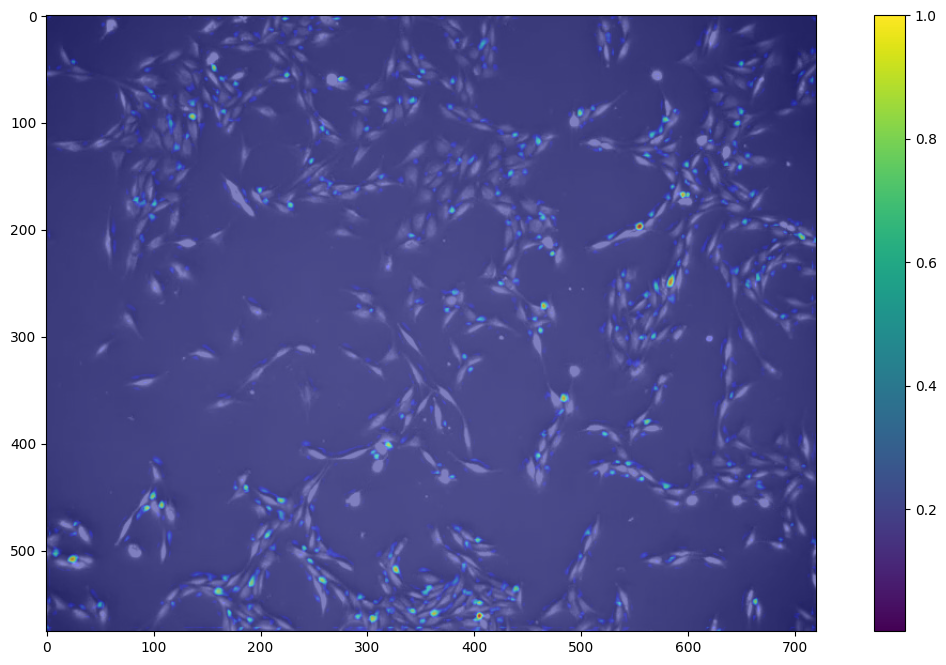

In [31]:
plt.figure(figsize=(15,8))
plt.imshow(np.clip(attended_img, 0, 1))
plt.colorbar()

In [32]:
print(ori_map.shape)

torch.Size([1, 36, 576, 720])


In [41]:
bin_size, h, w = ori_map.shape[1:]
ori_vals = torch.argmax(ori_map, dim=1) * 360 / bin_size 

In [44]:
ori_vals = ori_vals / ori_vals.max()
ori_heatmap = cv2.applyColorMap(np.uint8(255 * ori_vals), cv2.COLORMAP_HSV)
ori_heatmap = cv2.cvtColor(ori_heatmap, cv2.COLOR_BGR2HSV)
ori_heatmap = np.float32(ori_heatmap) / 255
#img_vis = cv2.cvtColor(cv2.imread(image_path1), cv2.COLOR_BGR2GRAY)
img_2_ = np.float32(img1.squeeze(0).permute(1, 2, 0)) #/ 255
_ori_attended_img = ori_heatmap + np.float32(img_2_)
ori_attended_img = _ori_attended_img / np.max(_ori_attended_img)

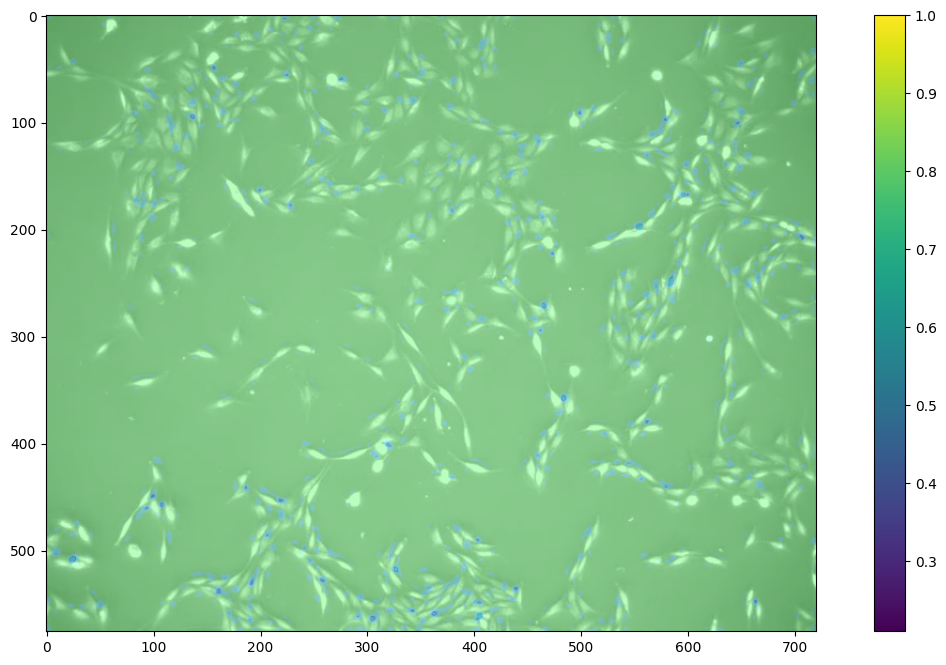

In [45]:
plt.figure(figsize=(15,8))
plt.imshow(np.clip(ori_attended_img, 0, 1))
plt.colorbar()

In [6]:
#img1 = torch.transpose(img1, 0, 1)
#img1 = torch.transpose(img1, 0, 2)

#img1.shape

torch.Size([3, 576, 720])

In [8]:
x = img1.unsqueeze(0)
x = x.unsqueeze(0)
x = x.cuda()
x.shape

torch.Size([1, 1, 576, 720])

In [ ]:
def _extract_features(self, path, model1):
        image = self.read_image(path)

        score_maps, ori_maps = self._compute_score_maps(image, model1)

        im_pts = self._estimate_keypoint_coordinates(score_maps)

        im_pts, ori_values = self._estimate_orientations(im_pts, ori_maps)

        descriptors = self._extract_descriptors(image, im_pts)

        return im_pts, descriptors, ori_values

In [9]:
features_key, features_ori = model(x)


: 

: 